<h1><center>Northeastern University</center></h1>
<h1><center>EECE 7150 Autonomous Field Robotics</center></h1>
<h1><center>HW5 Submission</center></h1>
<h3><center>Yash Mewada</center></h3>
<h3><center>Date: 26th Oct, 2023</center></h3>

<h3>Structure from Motion</h3>
Steps for projecting 3D points from serires of 2D images:
<ol>
    <li>Read two consecutive images and perform keypoint detector and matcher through these images.</li>
    <li>Estimate the Fundamemtal matrix using these matched keypoints.</li>
    <li>Estimate the Essential matrix from the Fundamental matrix.</li>
    <li>Estimate the camera pose from the Essential matrix.</li>
    <li>Triangulate the 3D points from the camera pose and matched keypoints.</li>
    <li>Repeat the above steps for all the images in the sequence.</li>







In [36]:
import numpy as np
import cv2
import os
import math
import open3d as o3d
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from matplotlib import pyplot as plt
%matplotlib inline

"""
Author: Yash Mewada
Date: 10/26/2023
"""

'\nAuthor: Yash Mewada\nDate: 10/26/2023\n'

In [37]:
class colors:
    """
    Class to define colors for printing
    """
    GREEN = '\033[92m'
    BLUE = '\033[94m'
    YELLOW = '\033[93m'
    END = '\033[0m'


In [38]:
class hw5:
    
    FM_8POINT = 0
    FM_RANSAC = 1
    FM_LMEDS = 2
    FM_7POINT = 3
    
    def __init__(self,dataset):
        """
        Constructor to initialize the dataset
        Args: Path to the dataset
        """
        self.dataset = dataset
        self.K = np.array([[1,0,0],[0,1,0],[0,0,1]])
        
    def readImages(self):
        """
        Function to read images from the dataset
        """
        images = []
        files = sorted(os.listdir(self.dataset))
        for i in range(len(files)):
            files[i] = self.dataset + files[i]
            img = cv2.imread(files[i])
            image = cv2.resize(img, (0,0), fx=0.5, fy=0.5) 
            images.append(image)
        width = images[0].shape[1]
        height = images[0].shape[0]
        self.K = np.array([[width,0,width/2],
                           [0,height,height/2],
                           [0,0,1]])
        return images
    
    def featureDetector(self,img1,img2,doORB=False):
        """
        Function to detect features in the images
        Args: img1, img2, doORB
        Returns: img3, goodkp1, goodkp2
        """
        img1 = cv2.cvtColor(img1,cv2.COLOR_BGR2GRAY)
        img2 = cv2.cvtColor(img2,cv2.COLOR_BGR2GRAY)
        
        if doORB:
            featureDetector = cv2.ORB_create()
        else:
            featureDetector = cv2.SIFT_create()
        
        kp1,des1 = featureDetector.detectAndCompute(img1,None)
        kp2,des2 = featureDetector.detectAndCompute(img2,None)
        
        matches = sorted(cv2.BFMatcher(cv2.NORM_L1,crossCheck=True).match(des1,des2),key=lambda x:x.distance)
        goodkp2 = [kp2[mat.trainIdx] for mat in matches]
        goodkp1 = [kp1[mat.queryIdx] for mat in matches]
        #print(goodkp1[0].pt)

        img3 = cv2.drawMatches(img1,kp1,img2,kp2,matches[:50],None,flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
        
        goodkp1 = np.float32([kp.pt for kp in goodkp1])
        goodkp2 = np.float32([kp.pt for kp in goodkp2])
        return img3,goodkp1,goodkp2

    def normalizePoints(self,pts):
        """
        Normalize the points
        Args: pts
        Returns: new_ptst,T
        """
        new_ptst = np.empty_like(pts)
        center = (0,0)
        
        # Compute centers and average distances for each set of points            
        for i in range(len(pts)):
            center += pts[i]
        center /= len(pts)

        distance = 0.0
        for i in range(len(pts)):
            new_ptst[i] = pts[i] - center
            distance += np.linalg.norm(new_ptst[i])
        distance /= len(pts)
        # print("distance: ",distance)
        scale = np.sqrt(2)/distance
        for i in range(len(pts)):
            new_ptst[i] *= scale
        
        T = np.array([[scale,0,-center[0]*scale],
                      [0,scale,-center[1]*scale],
                      [0,0,1]])

        return new_ptst,T
    
    def RANSAC(self,pts1,pts2,reProjThreshold=3,maxIters=10000):
        """
        Ransac Implementation
        """
        if len(pts1) < 15 or len(pts2) < 15:
            print("Not enough points")
            return None
        else:
            num_iterations = math.inf
            iterations_done = 0
            num_sample = 5

            max_inlier_count = 0
            best_model = None
            bestError = math.inf

            prob_outlier = 0.5
            desired_prob = 0.95

            total_data = np.column_stack((pts1, pts2))  ## [ A | Y]
            data_size = len(total_data)

        #     # Adaptively determining the number of iterations
        #     while num_iterations > iterations_done:

        #         # shuffle the rows and take the first 'num_sample' rows as sample data
        #         np.random.shuffle(total_data)
        #         tempInliersPts = np.random.choice(data_size, num_sample, replace=False)
        #         tempInliers = []
        #         tempE = self.K.T @ F @ self.K
                
        #         for i in tempInliersPts:
        #             if i not in tempInliersPts:
        #                 ditance = np.abs(np.matmul(pts2[i],tempE))
        #                 if ditance < reProjThreshold:
        #                     tempInliers.append(i)
        #         sample_data = total_data[:num_sample, :]

        #         estimated_model = self.curve_fitting_model.fit(sample_data[:,:-1], sample_data[:, -1:]) ## [a b c]

        #         # count the inliers within the threshold
        #         y_cap = pts1.dot(estimated_model)
        #         err = np.abs(pts2 - y_cap.T)
        #         inlier_count = np.count_nonzero(err < reProjThreshold)

        #         # check for the best model 
        #         if inlier_count > max_inlier_count:
        #             max_inlier_count = inlier_count
        #             best_model = estimated_model


        #         prob_outlier = 1 - inlier_count/data_size
        #         print('# inliers:', inlier_count)
        #         print('# prob_outlier:', prob_outlier)
        #         num_iterations = math.log(1 - desired_prob)/math.log(1 - (1 - prob_outlier)**num_sample)
        #         iterations_done = iterations_done + 1

        #         print('# s:', iterations_done)
        #         print('# n:', num_iterations)
        #         print('# max_inlier_count: ', max_inlier_count)
            
        # return best_model
            
        
    def findFundametalMat(self,pts1,pts2,method=FM_8POINT):
        """
        Compute the fundamental matrix
        Args: pts1, pts2, method
        Returns: F
        """
        npts1,T1 = self.normalizePoints(pts1)
        npts2,T2 = self.normalizePoints(pts2)
        if method == self.FM_8POINT:
            # Estimate fundamental matrix using 8-point algorithm manually
            A = []
            for i in range(len(npts1)):
                x1 = npts1[i][0]
                y1 = npts1[i][1]
                x2 = npts2[i][0]
                y2 = npts2[i][1]
                A.append([x1*x2,x2*y1,x2,y2*x1,y2*y1,y2,x1,y1,1])
                # A.append([x1*x2,x1*y2,x1,y1*x2,y1*y2,y1,x2,y1,1])
            
            U,S,V = np.linalg.svd(A)
            F = V[-1].reshape(3,3)
            U,S,V = np.linalg.svd(F)
            minS = np.argmin(S)
            S[minS] = 0
            F = np.dot(U,np.dot(np.diag(S),V))
            F = np.dot(T2.T,np.dot(F,T1))  
            F = F/F[2,2] 
            return F
        
        elif method == self.FM_RANSAC:
            print("RANSAC TBD")
        
    def estimateEssentialMatrix(self,F):
        """
        Compute Essential Matrix from Fundamental Matrix
        """
        # E = np.matmul(F.T,np.matmul(np.diag([1,1,0]),F))
        # U,S,Vt = np.linalg.svd(E)
        # S[0] = S[1] = (S[0] + S[1]) / 2
        # S[2] = 0
        # E = U @ np.diag(S) @ Vt
        # E = E / np.linalg.norm(E)
        E = np.matmul(self.K.T,np.matmul(F,self.K))
        # E = cv2.findEssentialMat(pts1,pts2,self.K,cv2.RANSAC,0.999,1.0)[0]
        # U,S,Vt = np.linalg.svd(E)
        # s = np.array([1,1,0])
        # E = U @ np.diag(s) @ Vt
        return E
    def recoverPose(self,E,pts1,pts2):
        """
        Get the rotation and translation matrix from Essential Matrix
        Note: this implementation does not perform cheirality check i.e it does not check if the points are in front of the camera or not
        """
        
    def write_ascii_Ply(self,points,filename):
        """
        Write an ASCII output PLY file with the 3D x, y, z coordinates of the points separated by commas.
        """
        # print(points)
        pcd = o3d.geometry.PointCloud()
        pcd.points = o3d.utility.Vector3dVector(points)
        o3d.io.write_point_cloud(filename, pcd,write_ascii=True)
    
    def visualisePly(self,filename):
        pcd = o3d.io.read_point_cloud(filename)
        o3d.visualization.draw_geometries([pcd])
        
    def plot_camera(self,R,t,ax,scale=.5,depth=.5,faceColor='grey'):

        C = -t #camera center (in world coordinate system)
    
        #Generating camera coordinate axes
        axes = np.zeros((3,6))
        axes[0,1], axes[1,3],axes[2,5] = 1,1,1
        
        #Transforming to world coordinate system 
        axes = R.T.dot(axes)+C[:,np.newaxis]
    
        #Plotting axes
        ax.plot3D(xs=axes[0,:2],ys=axes[1,:2],zs=axes[2,:2],c='r')
        ax.plot3D(xs=axes[0,2:4],ys=axes[1,2:4],zs=axes[2,2:4],c='g')
        ax.plot3D(xs=axes[0,4:],ys=axes[1,4:],zs=axes[2,4:],c='b')
    
        #generating 5 corners of camera polygon 
        pt1 = np.array([[0,0,0]]).T #camera centre
        pt2 = np.array([[scale,-scale,depth]]).T #upper right 
        pt3 = np.array([[scale,scale,depth]]).T #lower right 
        pt4 = np.array([[-scale,-scale,depth]]).T #upper left
        pt5 = np.array([[-scale,scale,depth]]).T #lower left
        pts = np.concatenate((pt1,pt2,pt3,pt4,pt5),axis=-1)
        
        #Transforming to world-coordinate system
        pts = R.T.dot(pts)+C[:,np.newaxis]
        ax.scatter3D(xs=pts[0,:],ys=pts[1,:],zs=pts[2,:],c='k')
        
        #Generating a list of vertices to be connected in polygon
        verts = [[pts[:,0],pts[:,1],pts[:,2]], [pts[:,0],pts[:,2],pts[:,-1]],
                [pts[:,0],pts[:,-1],pts[:,-2]],[pts[:,0],pts[:,-2],pts[:,1]]]
        
        #Generating a polygon now..
        ax.add_collection3d(Poly3DCollection(verts, facecolors=faceColor,
                                             linewidths=1, edgecolors='k', alpha=.25))
        
             
        

Here the algorithm used for estimating Fundamental Matrix is : **Normalized 8-point algorithm**. The reason for that is orders of magnitude difference between coloumn of data matrix; hence the Least Square yields to poor and time consuming results. 

E [[   3.75490688    5.39371775 -101.51378598]
 [  -1.60112668   -1.51902003   31.21071026]
 [ 102.9101273   -32.07694866   -0.24206802]]
R [[ 9.99999856e-01  4.78497789e-04 -2.45005592e-04]
 [-4.78593277e-04  9.99999809e-01 -3.89828145e-04]
 [ 2.44819014e-04  3.89945347e-04  9.99999894e-01]]
t [[ 0.83365023]
 [-0.29173601]
 [-0.46895352]]
(194, 3)


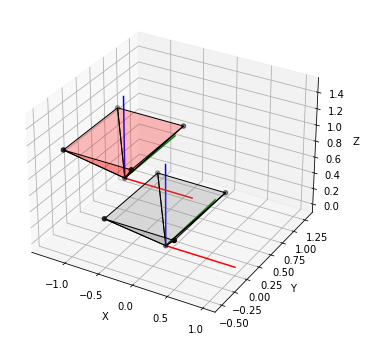

In [39]:
if __name__ == "__main__":
    dataset = "/home/mewada/Documents/eece7150/HW5/Dataset/buddha_images/"
    hw5 = hw5(dataset)
    images = hw5.readImages()
    E_list = []
    pts3d_list = []
    # for i in range(len(images)-1):
    #     matches,kp1,kp2 = hw5.featureDetector(images[i],images[i+1],doORB=False)
    #     e = cv2.findEssentialMat(kp1,kp2,hw5.K,cv2.RANSAC,0.999,1.0)[0]
    #     E_list.append(e)
    #     _,R,t,_ = cv2.recoverPose(e,kp1,kp2,hw5.K)
    #     pts_3d_homogeneous = cv2.triangulatePoints(np.eye(3,4),np.hstack((R,t)),kp1.T,kp2.T)
    #     pts_3d = cv2.convertPointsFromHomogeneous(pts_3d_homogeneous.T)
    #     pts_3d = pts_3d.squeeze()[:, :3]
    #     pts_3d = pts_3d.T
    #     pts_3d = np.reshape(pts_3d,(-1,3))
    #     pts3d_list.append(pts_3d)
    
    # fig,axis = plt.subplots()
    # axis = fig.add_subplot(111, projection='3d')
    # for i in range(len(pts3d_list)):
    #     axis.scatter(pts3d_list[i][:,0],pts3d_list[i][:,1],pts3d_list[i][:,2])
    # axis.set_xlabel('X Label')
    # axis.set_ylabel('Y Label')
    # axis.set_zlabel('Z Label')
    # plt.show()
    macthes,kp1,kp2 = hw5.featureDetector(images[0],images[1],doORB=False)
 
    F_cv2,_ = cv2.findFundamentalMat(kp1,kp2,cv2.FM_8POINT)
 
    F = hw5.findFundametalMat(kp1,kp2)
 
    # print("F",F)
    # print("F_new",F_cv2)
    # diff = F - F_cv2
    # diff = np.array2string(diff, formatter={'all': lambda x: f'{x:.5f}'})
    # print("diff",diff)
 
    E = hw5.estimateEssentialMatrix(F)
    print("E",E)
    E = cv2.findEssentialMat(kp1,kp2,hw5.K,cv2.RANSAC,0.999,1.0)[0]
    retval,R,t,mask = cv2.recoverPose(E,kp1,kp2,hw5.K)
    print("R",R)
    print("t",t)
    pts_3d_homogeneous = cv2.triangulatePoints(np.eye(3,4),np.hstack((R,t)),kp1.T,kp2.T)
    pts_3d = cv2.convertPointsFromHomogeneous(pts_3d_homogeneous.T)
    pts_3d = pts_3d.squeeze()[:, :3]
    pts_3d = pts_3d.T
    pts_3d = np.reshape(pts_3d,(-1,3))
    print(pts_3d.shape)
    fig = plt.figure(figsize=(9,6))
    ax = fig.add_subplot(111, projection='3d')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    # hw5.plot_camera(np.eye(3,3),np.zeros((3,)),ax)
    hw5.plot_camera(R,t[:,0],ax,faceColor='r')
    plt.show()
    

    